In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))
from core.viz import plot_line, create_subplot_grid, plot_bar, plot_statistical_strip
from core.s3 import S3AssetManager
import seaborn as sns
from scipy.stats import t
import math
import matplotlib.pyplot as plt


# Problama a resolver
## ¿Qué explorar?

### Revisión general de la data, calculo de valores medios por grupo

In [10]:
notebook_name = "adipell_granel"
s3 = S3AssetManager(notebook_name=notebook_name)

In [11]:
df = s3.read_excel("raw/raza/Datos seguimiento ADIFLOW.xlsx",sheet_name="Adiflow")
df.columns = [x.strip() for x in df.columns]
df['Maquina Empleada'] = df['Maquina Empleada'].str.lower()
df['Formula Adiflow'].value_counts(dropna = False)

1    25
0    18
Name: Formula Adiflow, dtype: int64

In [12]:


def mean_ci_95(series):
    """
    Dada una serie de valores numéricos,
    retorna un pd.Series con:
      - 'mean'
      - 'ci_lower'
      - 'ci_upper'
    usando el método paramétrico con t-student al 95%.
    """
    n = len(series)
    mean_ = series.mean()
    std_ = series.std(ddof=1)  # Desviación estándar muestral

    if n > 1:
        alpha = 0.05
        dof = n - 1
        t_val = t.ppf(1 - alpha / 2, df=dof)
        se = std_ / np.sqrt(n)
        ci_lower = mean_ - t_val * se
        ci_upper = mean_ + t_val * se
    else:
        # Con 1 o 0 muestras, no se puede estimar intervalo
        ci_lower = np.nan
        ci_upper = np.nan

    return pd.Series({
        'mean': mean_,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })



In [13]:
df.groupby(["Formula Adiflow"]).agg(
    {'Kilos Mp- Final':["sum"],
      "Presion":["mean"],
    "Carga":["mean",],
    "Temperatura":["mean"],
    "AW":["mean", "median", "sum"],
        "% Consistencia (pdi)":["mean"],
    "sakoff":["mean"],
     '% Humedad Final': ["mean"]
}).reset_index()

Formula Adiflow Kilos Mp- Final Presion      Carga Temperatura       AW  \
                              sum    mean       mean        mean     mean   
0               0          201300    25.0  10.611111   67.833333  0.64050   
1               1          228506    50.6  14.720000   69.360000  0.66316   

                 % Consistencia (pdi)    sakoff % Humedad Final  
  median     sum                 mean      mean            mean  
0  0.644  11.529             94.56875 -0.007312       10.842500  
1  0.663  16.579             94.36500  0.004139       11.054167

In [14]:
# Lista de columnas en las que calcularemos la media y su IC 95%
cols_mean_ci = ["Presion", "Carga", "Temperatura", "AW", "% Consistencia (pdi)", "sakoff", '% Humedad Final']

# Agrupamos por "Formula Adiflow" y luego aplicamos la función "mean_ci_95"
df_ci = (df
         .groupby("Formula Adiflow")[cols_mean_ci]
         .apply(lambda subgroup: subgroup.apply(mean_ci_95))
        )

df_ci

Presion      Carga  Temperatura        AW  \
Formula Adiflow                                                         
0               mean      25.000000  10.611111    67.833333  0.640500   
                ci_lower  25.000000   9.132578    65.044917  0.620964   
                ci_upper  25.000000  12.089645    70.621750  0.660036   
1               mean      50.600000  14.720000    69.360000  0.663160   
                ci_lower  46.816811  11.584232    67.613270  0.655603   
                ci_upper  54.383189  17.855768    71.106730  0.670717   

                          % Consistencia (pdi)    sakoff  % Humedad Final  
Formula Adiflow                                                            
0               mean                 94.568750 -0.007312        10.842500  
                ci_lower             93.662153 -0.010128        10.433841  
                ci_upper             95.475347 -0.004497        11.251159  
1               mean                 94.365000  0.004139        11.054167  
                ci_lower             93.495397 -0.002601        10.880962  
                ci_upper             95.234603  0.010880        11.227371

In [15]:
df["cambio_humedad"] = df["% Humedad Final"] - df["%Humedad inicial"]
df["cambio_peso"] = df["Kilos Mp- Final"] - df["Kilos Mp Inicial"]

In [16]:
agg_stat = dict(
    mean_carga =('Carga', "median"),
    count =('Carga', "count"),
    tot_kilos_fin =('Kilos Mp- Final', "sum"),
    mean_presion=('Presion', "median"),
    mean_temp = ('Temperatura', "mean"),
    mean_pdi =('% Consistencia (pdi)', "median"),
    mean_pdi2 =('% Consistencia (pdi)', "mean"),
    mean_kilos=('Kilos Mp Inicial', "median"),
    mean_sakoff=('sakoff', "median"),
    mean_kilos_init =('Kilos Mp Inicial', "median"),
    mean_kilos_end =('Kilos Mp- Final', "median"),

    mean_hum_init =('%Humedad inicial', "median"),
    mean_hum_end =('% Humedad Final', "median"),

    mean_hum_init2 =('%Humedad inicial', "mean"),
    mean_hum_end2 =('% Humedad Final', "mean"),

    mean_hum =('cambio_humedad', "median"),
    mean_peso=('cambio_peso', "median"),
    mean_aw =("AW", "median")
)
df_group = df.groupby(['Maquina Empleada', 'Formula Adiflow']).agg(**agg_stat).reset_index()
df_group["tot_ton_fin"] = df_group["tot_kilos_fin"]/1000

df_group["cambio_mean_peso"] = df_group["mean_kilos_end"] -  df_group["mean_kilos_init"]
df_group["cambio_mean_hum"] = df_group["mean_hum_end"] -  df_group["mean_hum_init"]
df_group["Formula Adiflow"].replace({0: "Sin adiflow", 1: "Con adiflow"}, inplace=True)

rename = {
    "mean_carga": "Valor medio Carga (Amp)",
    "mean_presion": "Valor medio Presión (PSI)",
    "mean_temp": "Valor medio Temperatura (°C)",
    "mean_pdi": "Valor medio PDI (%)",
    "mean_sakoff": "Valor medio Sakoff (%)",
}
df_group.rename(columns=rename, inplace=True)

In [17]:
df_group

,Maquina Empleada,Formula Adiflow,Valor medio Carga (Amp),count,tot_kilos_fin,Valor medio Presión (PSI),Valor medio Temperatura (°C),Valor medio PDI (%),mean_pdi2,mean_kilos,...,mean_hum_init,mean_hum_end,mean_hum_init2,mean_hum_end2,mean_hum,mean_peso,mean_aw,tot_ton_fin,cambio_mean_peso,cambio_mean_hum
0,pelet 1,Sin adiflow,13.0,7,88360,25.0,63.571429,94.70,94.700000,11951.0,...,9.20,10.700,9.680000,10.661667,1.325,-71.0,0.662,88.360,-71.0,1.500
1,pelet 1,Con adiflow,20.0,9,87240,45.0,69.444444,94.60,93.733333,8930.0,...,10.49,11.070,10.458889,11.117778,0.030,70.0,0.663,87.240,70.0,0.580
2,pelet 2 y 3,Sin adiflow,10.0,6,54380,25.0,71.166667,95.45,95.550000,9968.0,...,10.25,10.690,10.391667,10.864000,0.800,-84.0,0.625,54.380,-78.0,0.440
3,pelet 2 y 3,Con adiflow,12.0,7,58143,65.0,70.428571,94.90,94.616667,8018.0,...,10.30,10.895,10.128571,10.946667,0.695,-32.0,0.663,58.143,62.0,0.595
4,pelet 4,Sin adiflow,6.0,5,58560,25.0,69.800000,93.50,93.600000,10003.0,...,9.40,11.030,9.800000,11.038000,0.730,-48.0,0.648,58.560,-33.0,1.630
5,pelet 4,Con adiflow,8.0,9,83123,45.0,68.444444,94.00,95.200000,9130.0,...,10.60,10.900,10.761111,11.062222,0.630,-33.0,0.680,83.123,63.0,0.300


In [18]:
mean_sakoff = df.groupby(['Maquina Empleada', 'Formula Adiflow']).agg({"sakoff": "mean"})
mean_sakoff["sakoff"] = mean_sakoff["sakoff"]*100
mean_sakoff

sakoff
Maquina Empleada Formula Adiflow          
pelet 1          0               -0.897389
                 1                0.765244
pelet 2 y 3      0               -0.530597
                 1               -0.343655
pelet 4          0               -0.739384
                 1                0.651849

In [19]:
mean_sakoff = df.groupby(['Formula Adiflow']).agg({"sakoff": "mean"})
mean_sakoff["sakoff"] = mean_sakoff["sakoff"]*100
mean_sakoff

,sakoff
Formula Adiflow,
0,-0.731234
1,0.413930


In [20]:

def figure_base2(ax, df, index="peletizadora", values='eff_tot', title="", xlim=None):
    # Preparar DataFrame en formato pivot
    pivot_df = df.pivot(index=index, columns='Formula Adiflow', values=values).sort_index()
    pivot_ton = df.pivot(index=index, columns='Formula Adiflow', values='tot_ton_fin').sort_index()

    indices = np.arange(len(pivot_df))
    width = 0.35

    colors = {'Sin adiflow': '#94AF92', 'Con adiflow': '#1C8074'}

    # Barras horizontales
    bars_sin = ax.barh(
        indices - width/2,
        pivot_df['Sin adiflow'],
        height=width,
        label='Sin Adiflow',
        color=colors['Sin adiflow'],
        edgecolor='black'
    )
    bars_con = ax.barh(
        indices + width/2,
        pivot_df['Con adiflow'],
        height=width,
        label='Con Adiflow',
        color=colors['Con adiflow'],
        edgecolor='black'
    )

    # Agregar etiquetas de toneladas sobre las barras
    for bars, col in zip([bars_sin, bars_con], ['Sin adiflow', 'Con adiflow']):
        for bar, ton in zip(bars, pivot_ton[col]):
            width = bar.get_width()
            height = bar.get_height()
            if ton > 1:
                ax.text(width, bar.get_y() + bar.get_height()/2, f'{ton:.0f}(T)',
                        ha='right', va='center', fontsize=10)
            else:
                ax.text(width, bar.get_y() + bar.get_height()/2, '',
                        ha='right', va='center', fontsize=0)

    # Ejes y etiquetas
    ax.set_yticks(indices)
    ax.set_yticklabels(pivot_df.index.astype(str))

    # Etiquetas de eje X según variable
    value_labels = {
        'eff_tot': 'Eficiencia (%)',
        'ton_by_hour': 'Rendimiento (Ton/Hora)',
        'kwh_by_ton': 'Eficiencia (Kwh/Ton)',
        'Indice': 'Índice',
        'Valor medio PDI (%)': 'Durabilidad (%)'
    }
    val = value_labels.get(values, values)

    ax.set_xlabel(val)
    ax.set_ylabel(index)

    if title == '':
        ax.set_title(f'{val}', fontsize=20)
    else:
        ax.set_title(f'{title}', fontsize=20, fontweight='bold')

    ax.legend()
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Limitar eje X si se especifica
    if xlim:
        ax.set_xlim(xlim)

In [21]:
def subplot1x2(df1, df2, index1, index2, title1='Rendimiento por Peletizadora', title2='Rendimiento por Línea', file_name="by_pelet_linea"):

    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
    figure_base2(axes[0], df=df1, index=index1, values='ton_by_hour', title=title1)
    figure_base2(axes[1], df=df2, index=index2, values='ton_by_hour', title=title2)


    plt.tight_layout()
    #plt.savefig(f"{base_path_images}{file_name}.png")
    plt.show()

In [22]:
df_group.rename(columns={"Maquina Empleada": "Peletizadora", "mean_carga": "Carga Prom (A)", },
)
df_group["Producción (Ton)"] = df_group["tot_ton_fin"]

In [23]:
df_group.columns

Index(['Maquina Empleada', 'Formula Adiflow', 'Valor medio Carga (Amp)',
       'count', 'tot_kilos_fin', 'Valor medio Presión (PSI)',
       'Valor medio Temperatura (°C)', 'Valor medio PDI (%)', 'mean_pdi2',
       'mean_kilos', 'Valor medio Sakoff (%)', 'mean_kilos_init',
       'mean_kilos_end', 'mean_hum_init', 'mean_hum_end', 'mean_hum_init2',
       'mean_hum_end2', 'mean_hum', 'mean_peso', 'mean_aw', 'tot_ton_fin',
       'cambio_mean_peso', 'cambio_mean_hum', 'Producción (Ton)'],
      dtype='object')

In [24]:
df_group.rename(columns={
    "Maquina Empleada": "Pellet Maquine",
    "Valor medio Carga (Amp)": "Mean Load (A)",
     "Valor medio Temperatura (°C)": "Mean Temp (°C)",
    "Valor medio Presión (PSI)": "Mean Pressure (PSI)"
},inplace=True)
df_group

,Pellet Maquine,Formula Adiflow,Mean Load (A),count,tot_kilos_fin,Mean Pressure (PSI),Mean Temp (°C),Valor medio PDI (%),mean_pdi2,mean_kilos,...,mean_hum_end,mean_hum_init2,mean_hum_end2,mean_hum,mean_peso,mean_aw,tot_ton_fin,cambio_mean_peso,cambio_mean_hum,Producción (Ton)
0,pelet 1,Sin adiflow,13.0,7,88360,25.0,63.571429,94.70,94.700000,11951.0,...,10.700,9.680000,10.661667,1.325,-71.0,0.662,88.360,-71.0,1.500,88.360
1,pelet 1,Con adiflow,20.0,9,87240,45.0,69.444444,94.60,93.733333,8930.0,...,11.070,10.458889,11.117778,0.030,70.0,0.663,87.240,70.0,0.580,87.240
2,pelet 2 y 3,Sin adiflow,10.0,6,54380,25.0,71.166667,95.45,95.550000,9968.0,...,10.690,10.391667,10.864000,0.800,-84.0,0.625,54.380,-78.0,0.440,54.380
3,pelet 2 y 3,Con adiflow,12.0,7,58143,65.0,70.428571,94.90,94.616667,8018.0,...,10.895,10.128571,10.946667,0.695,-32.0,0.663,58.143,62.0,0.595,58.143
4,pelet 4,Sin adiflow,6.0,5,58560,25.0,69.800000,93.50,93.600000,10003.0,...,11.030,9.800000,11.038000,0.730,-48.0,0.648,58.560,-33.0,1.630,58.560
5,pelet 4,Con adiflow,8.0,9,83123,45.0,68.444444,94.00,95.200000,9130.0,...,10.900,10.761111,11.062222,0.630,-33.0,0.680,83.123,63.0,0.300,83.123


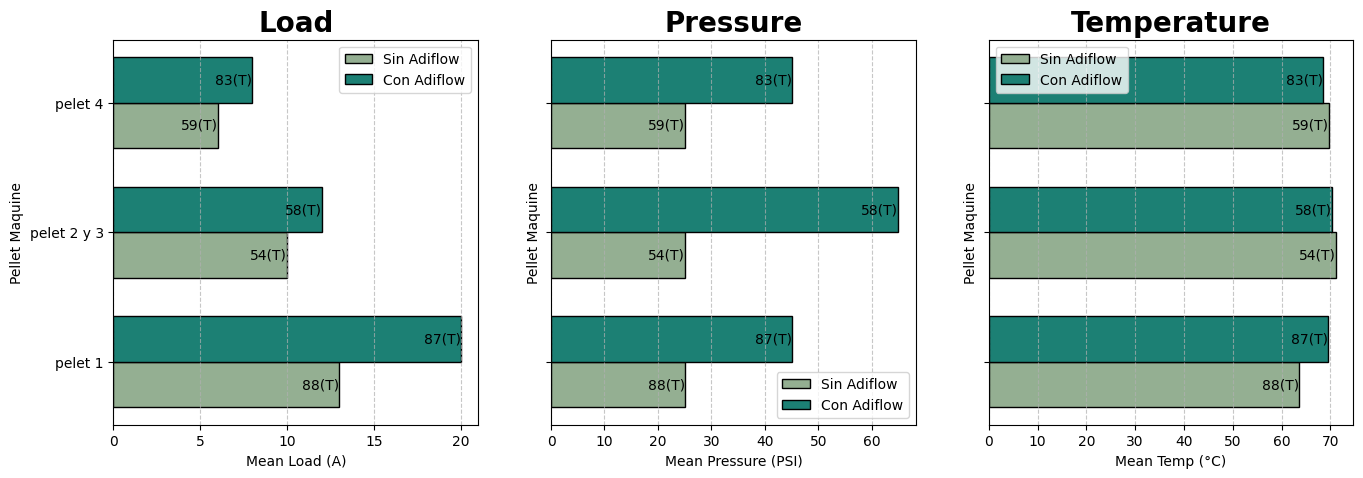

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
figure_base2(axes[0], df=df_group, index="Pellet Maquine", values='Mean Load (A)', title="Load")
figure_base2(axes[1], df=df_group, index="Pellet Maquine", values='Mean Pressure (PSI)', title="Pressure")
figure_base2(axes[2], df=df_group, index="Pellet Maquine", values='Mean Temp (°C)', title="Temperature")

#figure_base2(axes[1,0], df=df_group, index="Maquina Empleada", values='cambio_mean_peso', title="Cambio Peso")
#figure_base2(axes[1,1], df=df_group, index="Maquina Empleada", values='cambio_mean_hum', title="Cambio Humedad")
#figure_base2(axes[1,2], df=df_group, index="Maquina Empleada", values='mean_pdi', title="PDI")
#plt.subplots_adjust(hspace=1)  # <--- Aquí agregas el espacio entre filas
#plt.savefig(f"{ROOT_IMAGEN}/sumary_maquine.png", dpi=300, bbox_inches='tight')  # <-- Guarda el gráfico

#plt.subplots_adjust(wspace=0.1)

In [26]:
df_group["Valor medio Sakoff (%)"] = df_group["Valor medio Sakoff (%)"]*100

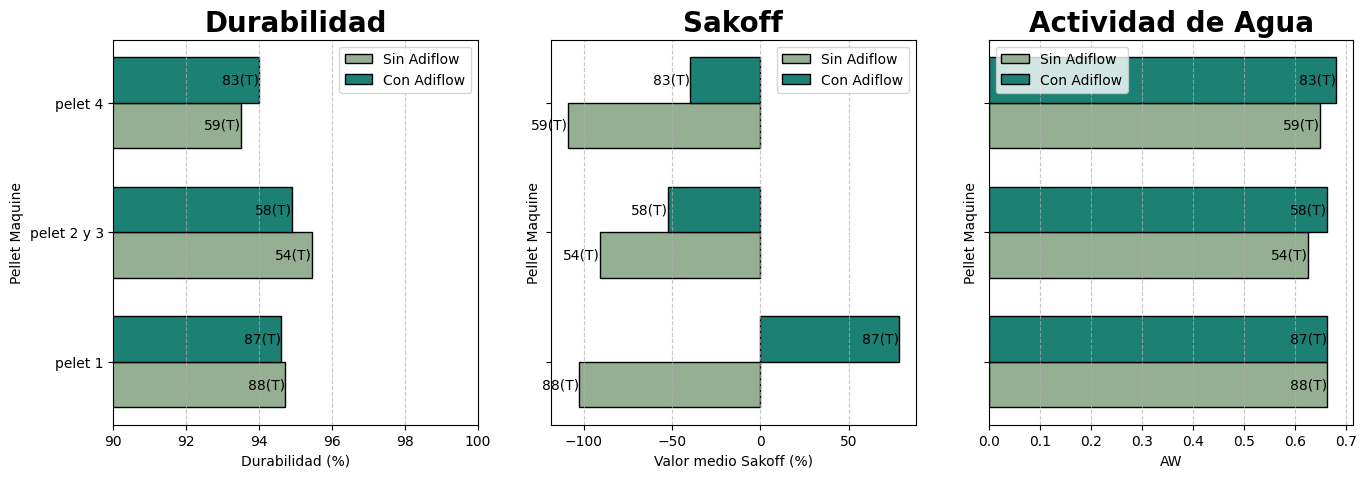

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

figure_base2(axes[0], df=df_group, index="Pellet Maquine", values='Valor medio PDI (%)', title="Durabilidad", xlim=(90, 100))
df_group['Valor medio Sakoff (%)'] = df_group['Valor medio Sakoff (%)']*100
figure_base2(axes[1], df=df_group, index="Pellet Maquine", values='Valor medio Sakoff (%)', title="Sakoff")
df_group.rename(columns={"mean_aw": "AW"}, inplace=True)
figure_base2(axes[2], df=df_group, index="Pellet Maquine", values='AW', title="Actividad de Agua")
#figure_base2(axes[2], df=df_group, index="Maquina Empleada", values='Producción (Ton)', title="Toneladas Finales")

#figure_base2(axes[1,0], df=df_group, index="Maquina Empleada", values='cambio_mean_peso', title="Cambio Peso")
#figure_base2(axes[1,1], df=df_group, index="Maquina Empleada", values='cambio_mean_hum', title="Cambio Humedad")
#figure_base2(axes[1,2], df=df_group, index="Maquina Empleada", values='mean_pdi', title="PDI")
#plt.subplots_adjust(hspace=1)  # <--- Aquí agregas el espacio entre filas
#plt.savefig(f"{ROOT_IMAGEN}/sumary_calidad.png", dpi=300, bbox_inches='tight')

In [28]:
df_group


,Pellet Maquine,Formula Adiflow,Mean Load (A),count,tot_kilos_fin,Mean Pressure (PSI),Mean Temp (°C),Valor medio PDI (%),mean_pdi2,mean_kilos,...,mean_hum_end,mean_hum_init2,mean_hum_end2,mean_hum,mean_peso,AW,tot_ton_fin,cambio_mean_peso,cambio_mean_hum,Producción (Ton)
0,pelet 1,Sin adiflow,13.0,7,88360,25.0,63.571429,94.70,94.700000,11951.0,...,10.700,9.680000,10.661667,1.325,-71.0,0.662,88.360,-71.0,1.500,88.360
1,pelet 1,Con adiflow,20.0,9,87240,45.0,69.444444,94.60,93.733333,8930.0,...,11.070,10.458889,11.117778,0.030,70.0,0.663,87.240,70.0,0.580,87.240
2,pelet 2 y 3,Sin adiflow,10.0,6,54380,25.0,71.166667,95.45,95.550000,9968.0,...,10.690,10.391667,10.864000,0.800,-84.0,0.625,54.380,-78.0,0.440,54.380
3,pelet 2 y 3,Con adiflow,12.0,7,58143,65.0,70.428571,94.90,94.616667,8018.0,...,10.895,10.128571,10.946667,0.695,-32.0,0.663,58.143,62.0,0.595,58.143
4,pelet 4,Sin adiflow,6.0,5,58560,25.0,69.800000,93.50,93.600000,10003.0,...,11.030,9.800000,11.038000,0.730,-48.0,0.648,58.560,-33.0,1.630,58.560
5,pelet 4,Con adiflow,8.0,9,83123,45.0,68.444444,94.00,95.200000,9130.0,...,10.900,10.761111,11.062222,0.630,-33.0,0.680,83.123,63.0,0.300,83.123


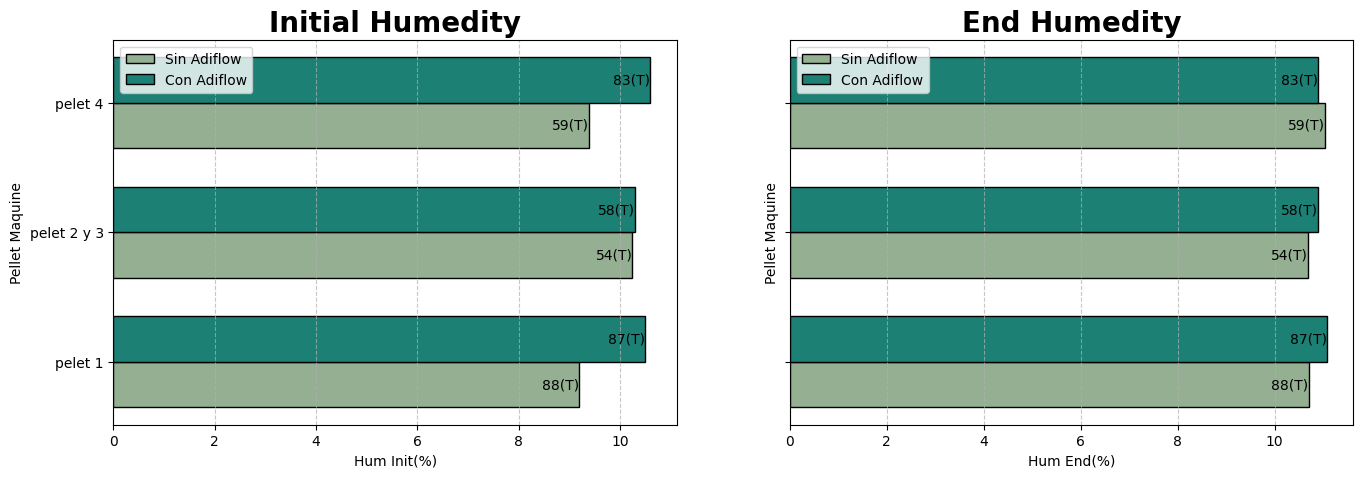

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
df_group.rename(columns={"mean_hum_init": "Hum Init(%)"}, inplace=True)
figure_base2(axes[0], df=df_group, index="Pellet Maquine", values='Hum Init(%)', title="Initial Humedity")
df_group.rename(columns={"mean_hum_end": "Hum End(%)"}, inplace=True)
figure_base2(axes[1], df=df_group, index="Pellet Maquine", values='Hum End(%)', title="End Humedity")

#figure_base2(axes[1,0], df=df_group, index="Maquina Empleada", values='cambio_mean_peso', title="Cambio Peso")
#figure_base2(axes[1,1], df=df_group, index="Maquina Empleada", values='cambio_mean_hum', title="Cambio Humedad")
#figure_base2(axes[1,2], df=df_group, index="Maquina Empleada", values='mean_pdi', title="PDI")
#plt.subplots_adjust(hspace=1)  # <--- Aquí agregas el espacio entre filas
#plt.savefig(f"{ROOT_IMAGEN}/sumary_hum.png", dpi=300, bbox_inches='tight')

In [30]:
df_group.columns

Index(['Pellet Maquine', 'Formula Adiflow', 'Mean Load (A)', 'count',
       'tot_kilos_fin', 'Mean Pressure (PSI)', 'Mean Temp (°C)',
       'Valor medio PDI (%)', 'mean_pdi2', 'mean_kilos',
       'Valor medio Sakoff (%)', 'mean_kilos_init', 'mean_kilos_end',
       'Hum Init(%)', 'Hum End(%)', 'mean_hum_init2', 'mean_hum_end2',
       'mean_hum', 'mean_peso', 'AW', 'tot_ton_fin', 'cambio_mean_peso',
       'cambio_mean_hum', 'Producción (Ton)'],
      dtype='object')

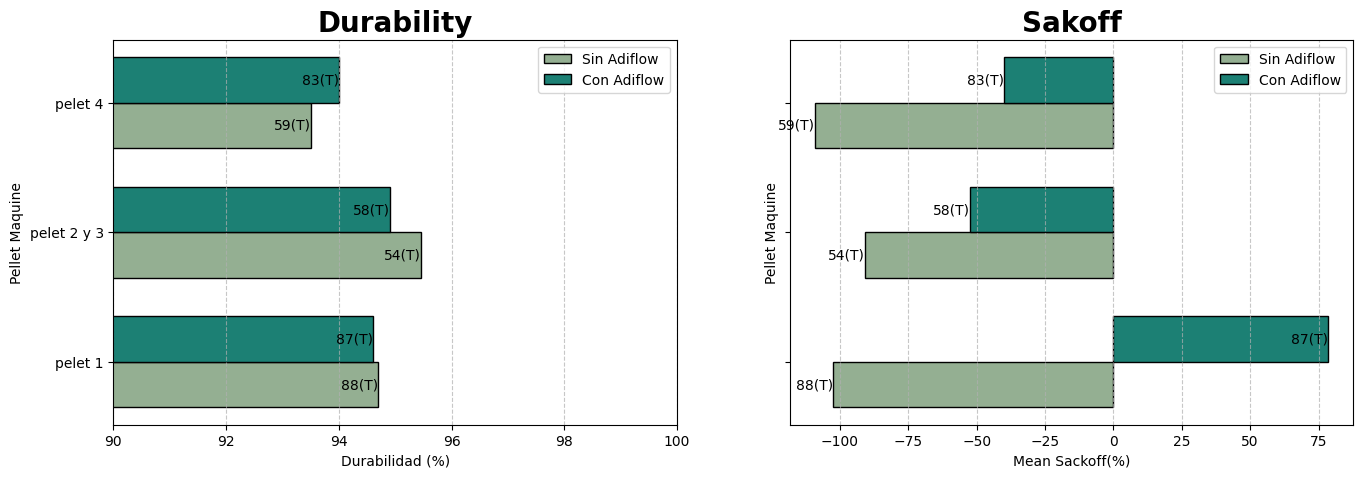

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
df_group.rename(columns={"Valor medio Sakoff (%)": "Mean Sackoff(%)"}, inplace=True)
figure_base2(axes[0], df=df_group, index="Pellet Maquine", values='Valor medio PDI (%)', title="Durability", xlim=(90, 100))

figure_base2(axes[1], df=df_group, index="Pellet Maquine", values='Mean Sackoff(%)', title="Sakoff")
#figure_base2(axes[2], df=df_group, index="Maquina Empleada", values='Producción (Ton)', title="Toneladas Finales")

#figure_base2(axes[1,0], df=df_group, index="Maquina Empleada", values='cambio_mean_peso', title="Cambio Peso")
#figure_base2(axes[1,1], df=df_group, index="Maquina Empleada", values='cambio_mean_hum', title="Cambio Humedad")
#figure_base2(axes[1,2], df=df_group, index="Maquina Empleada", values='mean_pdi', title="PDI")
#plt.subplots_adjust(hspace=1)  # <--- Aquí agregas el espacio entre filas
#plt.savefig(f"{ROOT_IMAGEN}/sumary_calidad.png", dpi=300, bbox_inches='tight')

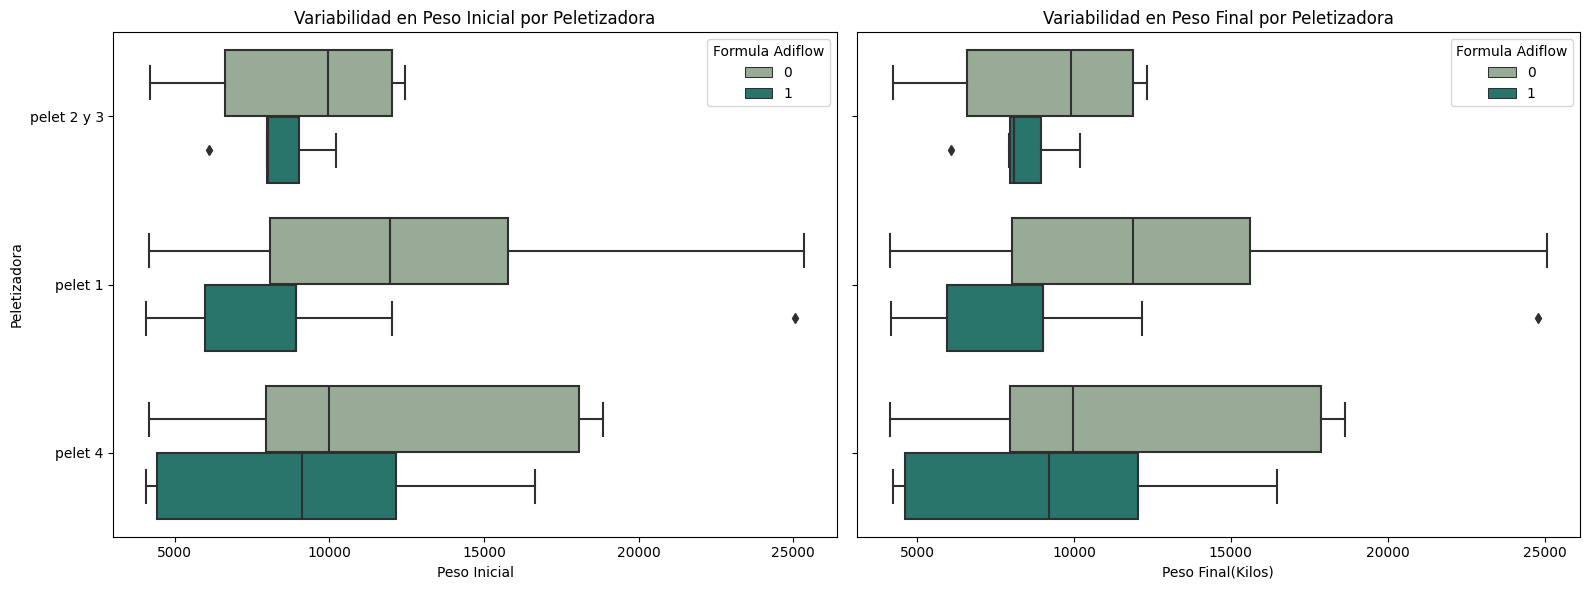

In [34]:
colors = {0: '#94AF92',1:'#1C8074'}

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Subplot 1: Peso inicial
sns.boxplot(
    data=df,
    x='Kilos Mp Inicial',
    y='Maquina Empleada',
    hue='Formula Adiflow',
    ax=axes[0],
    orient='h',
    palette=colors
)
axes[0].set_title("Variabilidad en Peso Inicial por Peletizadora")
axes[0].set_xlabel("Peso Inicial")
axes[0].set_ylabel("Peletizadora")

# Subplot 2: Peso final
sns.boxplot(
    data=df,
    x='Kilos Mp- Final',
    y='Maquina Empleada',
    hue='Formula Adiflow',
    ax=axes[1],
    orient='h',
    palette=colors
)
axes[1].set_title("Variabilidad en Peso Final por Peletizadora")
axes[1].set_xlabel("Peso Final(Kilos)")
axes[1].set_ylabel("")

plt.tight_layout()
#plt.savefig(f"{ROOT_IMAGEN}/box_peso.png", dpi=300, bbox_inches='tight')

plt.show()


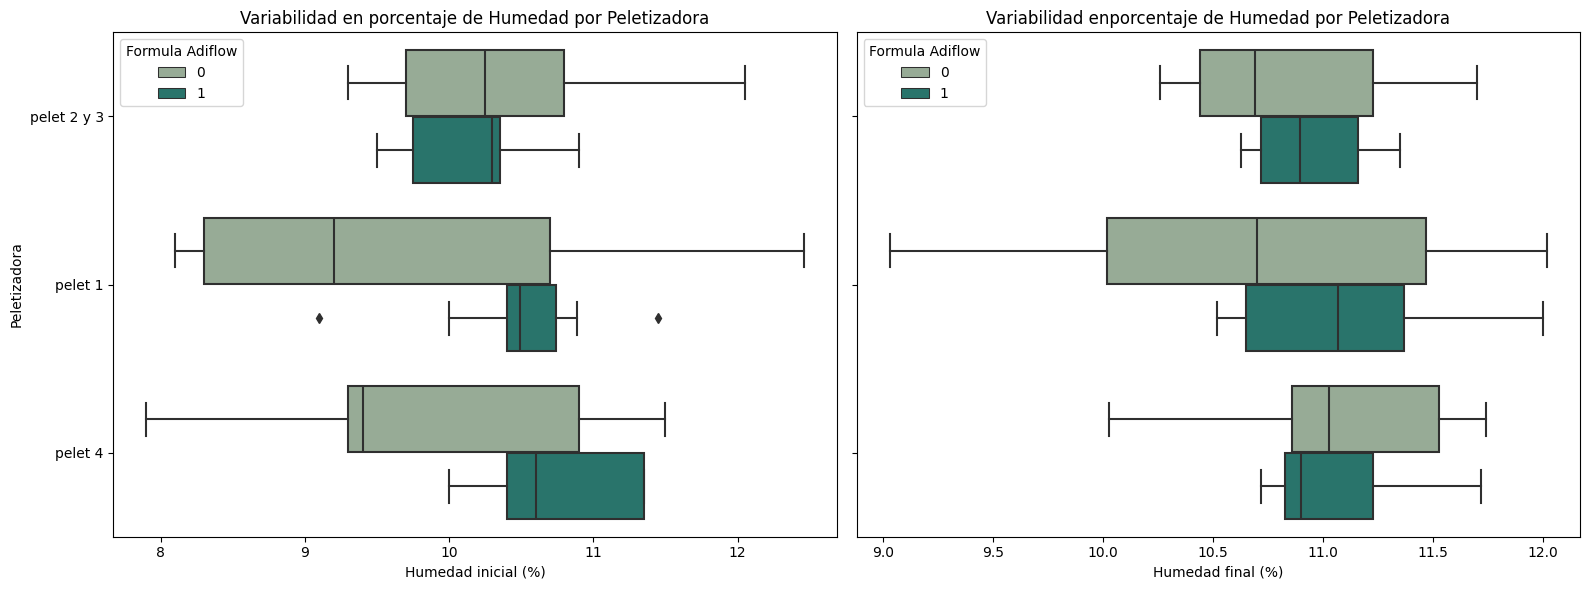

In [35]:

colors = {0: '#94AF92',1:'#1C8074'}

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Subplot 1: Peso inicial
sns.boxplot(
    data=df,
    x='%Humedad inicial',
    y='Maquina Empleada',
    hue='Formula Adiflow',
    ax=axes[0],
    orient='h',
    palette=colors
)
axes[0].set_title("Variabilidad en porcentaje de Humedad por Peletizadora")
axes[0].set_xlabel("Humedad inicial (%)")
axes[0].set_ylabel("Peletizadora")

# Subplot 2: Peso final
sns.boxplot(
    data=df,
    x='% Humedad Final',
    y='Maquina Empleada',
    hue='Formula Adiflow',
    ax=axes[1],
    orient='h',
    palette=colors
)
axes[1].set_title("Variabilidad enporcentaje de Humedad por Peletizadora")
axes[1].set_xlabel("Humedad final (%)")
axes[1].set_ylabel("")

plt.tight_layout()
#plt.savefig(f"{ROOT_IMAGEN}/box_humedad.png", dpi=300, bbox_inches='tight')

plt.show()
